In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [3]:
from zipfile import ZipFile
import os

#uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
#zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
#zip_file = ZipFile(zip_path)
#zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)

## Raw Data Visualization

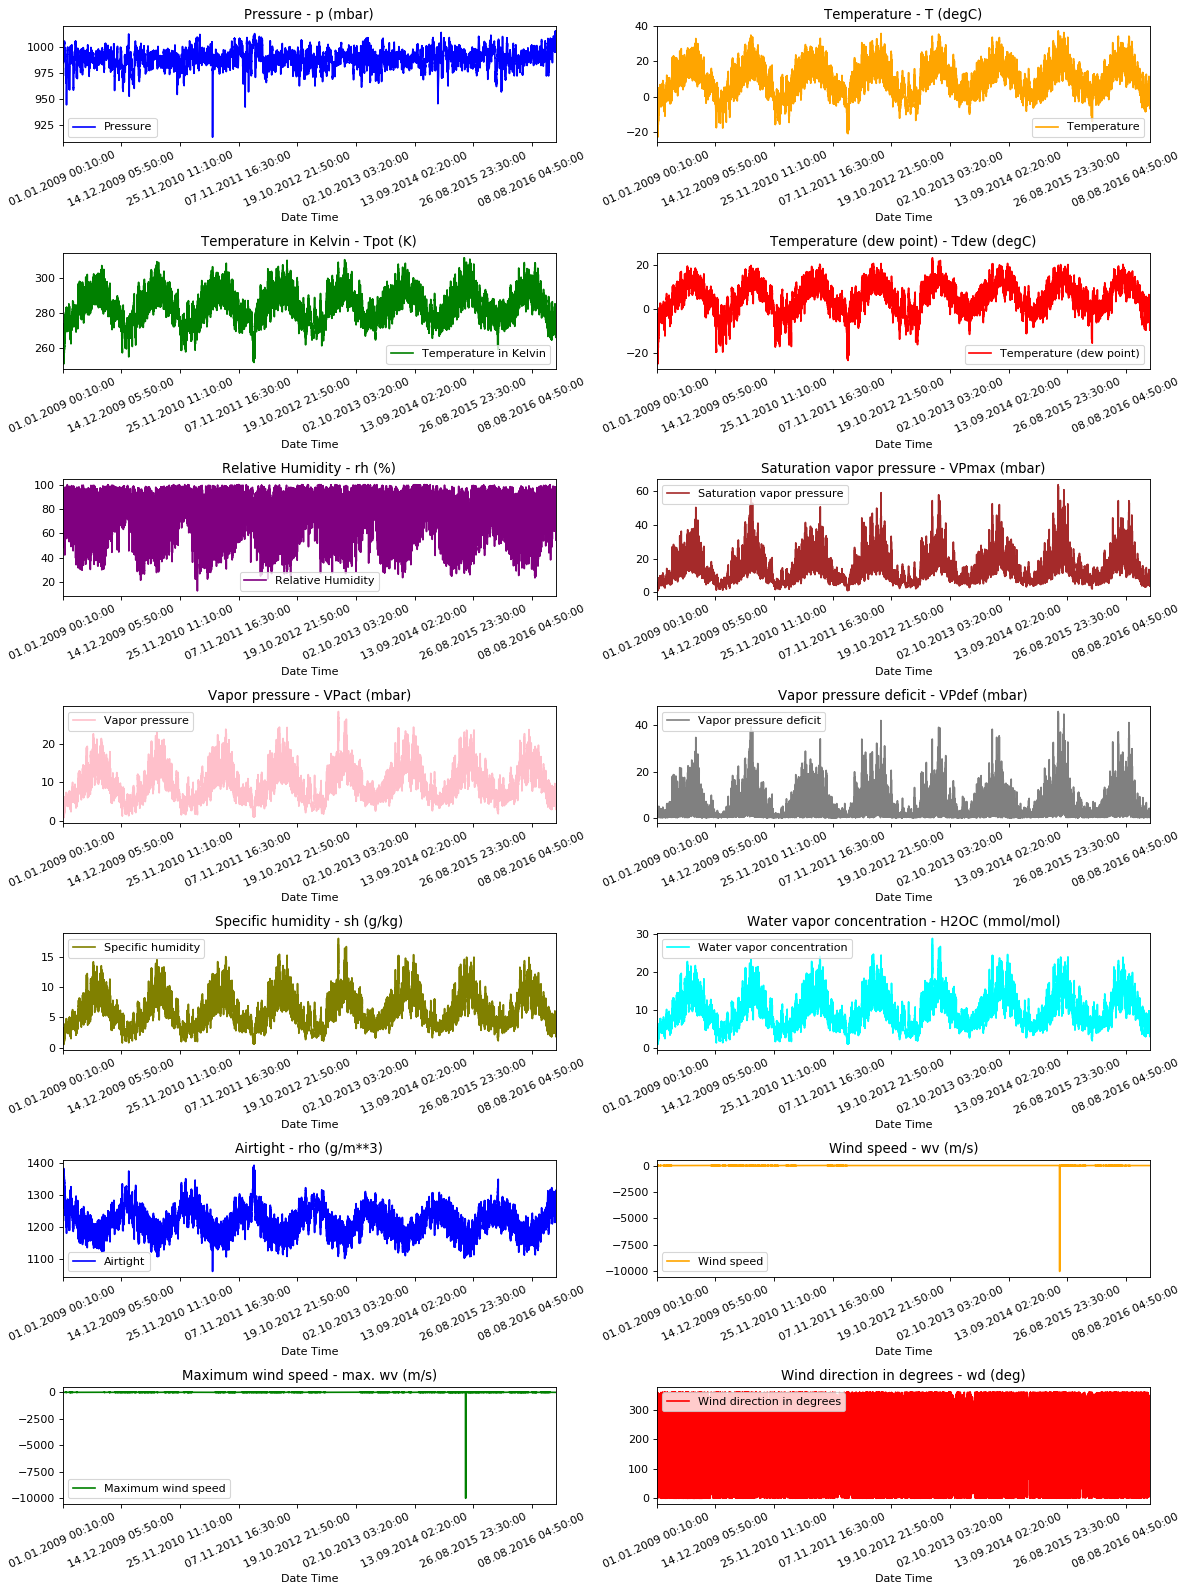

In [4]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

This heat map shows the correlation between different features.

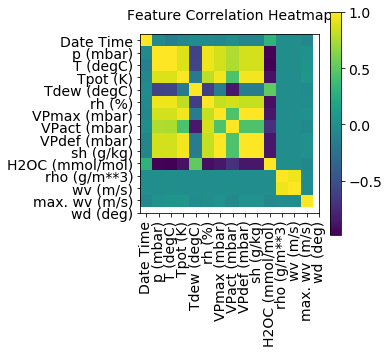

In [5]:

def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)


## Data Preprocessing

Here we are picking ~300,000 data points for training. Observation is recorded every
10 mins, that means 6 times per hour. We will resample one point per hour since no
drastic change is expected within 60 minutes. We do this via the `sampling_rate`
argument in `timeseries_dataset_from_array` utility.

We are tracking data from past 720 timestamps (720/6=120 hours). This data will be
used to predict the temperature after 72 timestamps (76/6=12 hours).

Since every feature has values with
varying ranges, we do normalization to confine feature values to a range of `[0, 1]` before
training a neural network.
We do this by subtracting the mean and dividing by the standard deviation of each feature.

71.5 % of the data will be used to train the model, i.e. 300,693 rows. `split_fraction` can
be changed to alter this percentage.

The model is shown data for first 5 days i.e. 720 observations, that are sampled every
hour. The temperature after 72 (12 hours * 6 observation per hour) observation will be
used as a label.

In [6]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 6

past = 720
future = 72
learning_rate = 0.001
batch_size = 256
epochs = 10


def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std


We can see from the correlation heatmap, few parameters like Relative Humidity and
Specific Humidity are redundant. Hence we will be using select features, not all.

In [7]:
print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
features = df[selected_features]
features.index = df[date_time_key]
features.head()

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

The selected parameters are: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


# Training dataset

The training dataset labels starts from the 792nd observation (720 + 72).

In [8]:
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[1]]

sequence_length = int(past / step)

The `timeseries_dataset_from_array` function takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as length of the
sequences/windows, spacing between two sequence/windows, etc., to produce batches of
sub-timeseries inputs and targets sampled from the main timeseries.

In [9]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

## Validation dataset

The validation dataset must not contain the last 792 rows as we won't have label data for
those records, hence 792 must be subtracted from the end of the data.

The validation label dataset must start from 792 after train_split, hence we must add
past + future (792) to label_start.

In [10]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 120, 7)
Target shape: (256, 1)


## Training

In [11]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 7)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                5120      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


In [ ]:
path_checkpoint = "LSTM_model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
1172/1172 [==============================] - ETA: 0s - loss: 0.1886
Epoch 00001: val_loss improved from inf to 0.15465, saving model to LSTM_model_checkpoint.h5
1172/1172 [==============================] - 490s 418ms/step - loss: 0.1886 - val_loss: 0.1546
Epoch 2/10
1172/1172 [==============================] - ETA: 0s - loss: 0.1264
Epoch 00002: val_loss improved from 0.15465 to 0.13649, saving model to LSTM_model_checkpoint.h5
1172/1172 [==============================] - 476s 406ms/step - loss: 0.1264 - val_loss: 0.1365
Epoch 3/10
 346/1172 [=======>......................] - ETA: 4:48 - loss: 0.1168

In [ ]:

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

## Prediction

The trained model above is now able to make predictions for 5 sets of values from
validation set.

In [ ]:

def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )